# Test drive - Cointegration & Pairs Trading

Testing some concepts with some pre-coded functions on VAR and Time Series

In [60]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np

# Reuters API
import eikon as ek
ek.set_app_id('D79B714919385CD9D749D1')

# Statistical models
import statsmodels
from statsmodels.tsa.stattools import coint

# Plotting
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})  # set figure size

## Data

Get basket of commodities CLOSE price data since 2009 to 31-May-2016. Motivation for this basket:
* correlation between Crude, Coal, Gas, Power and Carbon
* including most liquid contracts only to allow more position taking in trading strategies

In [40]:
comm_list = [
    # Crude
    "LCOc1",  # Brent
    "LGOc1",  # Brent heating oil
    "CLc1",  # WTI
    "HOc1",  # WTI heating oil
    "CFI2Zc1",  # Carbon
    "TRAPI2Mc1",  # Coal
    "TRGBNBPMc1",  # NBP Gas
    "TRNLTTFMc1",  # TTF Gas
    "TRDEBMc1",  # Power - Germany
    "TRFRBMc1",  # Power - France
    "TRESBMc1",  # Power - Spain
    "TRGBBMc1"  # Power - UK
]

## Define data range
# today = datetime.today()
# one_day = timedelta(days=1)
# yesterday = today - one_day
start_date = datetime(2009, 1, 1)
end_date = datetime(2016, 5, 31)

list_dfs = []
for k in comm_list:
    dic = ek.get_timeseries([k], start_date=start_date, end_date=end_date, interval='daily', fields=['CLOSE'])
    print "Finished ", k
    df = dic[k]  # put from dic into df
    df.columns = [k]  # rename columns to RICs code
    list_dfs += [df]

# Outer join
oj = pd.concat(list_dfs, axis=1, join='outer')


Finished  LCOc1
Finished  LGOc1
Finished  CLc1
Finished  HOc1
Finished  CFI2Zc1
Finished  TRAPI2Mc1
Finished  TRGBNBPMc1
Finished  TRNLTTFMc1
Finished  TRDEBMc1
Finished  TRFRBMc1
Finished  TRESBMc1
Finished  TRGBBMc1


In [41]:
oj.head()

,LCOc1,LGOc1,CLc1,HOc1,CFI2Zc1,TRAPI2Mc1,TRGBNBPMc1,TRNLTTFMc1,TRDEBMc1,TRFRBMc1,TRESBMc1,TRGBBMc1
2009-01-01,NaN,NaN,NaN,NaN,NaN,82.00,60.55,21.45,62.00,66.00,52.5,60.50
2009-01-02,46.91,427.75,46.34,1.4803,15.55,80.75,60.55,20.15,62.00,68.75,53.0,60.50
2009-01-05,49.62,478.75,48.81,1.5763,15.38,85.00,57.00,20.75,58.40,67.50,52.5,59.75
2009-01-06,50.53,514.50,48.58,1.6263,15.69,89.00,60.75,23.06,60.05,69.50,52.5,62.00
2009-01-07,45.86,500.50,42.63,1.5431,15.45,86.50,60.75,22.19,60.05,68.00,53.4,62.00


### Clean-up

In [42]:
# Do some data prep on missing values
df = oj.copy()

## NaN indicator column
# for k in df:
#     s = 'NaN.' + k
#     df[s] = df[k].isnull()

# forward fill NaN's with previous value
df = df.fillna(method='pad')

# fill with zeroes what doesn't have a past value
df = df.fillna(0)

In [43]:
df.head()

,LCOc1,LGOc1,CLc1,HOc1,CFI2Zc1,TRAPI2Mc1,TRGBNBPMc1,TRNLTTFMc1,TRDEBMc1,TRFRBMc1,TRESBMc1,TRGBBMc1
2009-01-01,0.00,0.00,0.00,0.0000,0.00,82.00,60.55,21.45,62.00,66.00,52.5,60.50
2009-01-02,46.91,427.75,46.34,1.4803,15.55,80.75,60.55,20.15,62.00,68.75,53.0,60.50
2009-01-05,49.62,478.75,48.81,1.5763,15.38,85.00,57.00,20.75,58.40,67.50,52.5,59.75
2009-01-06,50.53,514.50,48.58,1.6263,15.69,89.00,60.75,23.06,60.05,69.50,52.5,62.00
2009-01-07,45.86,500.50,42.63,1.5431,15.45,86.50,60.75,22.19,60.05,68.00,53.4,62.00


In [44]:
df.shape

(1929, 12)

## Finding cointegrated pair

Look in commodities basket to see if any of them are cointegrated. Idea taken from this [Quantopian notebook](https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Updated%20Pairs%20Trading%20Lecture%3A%20Now%20With%20Less%20Wind%20Resistance%22.ipynb)

In [63]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # 5% C.L. to reject null hypothesis
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


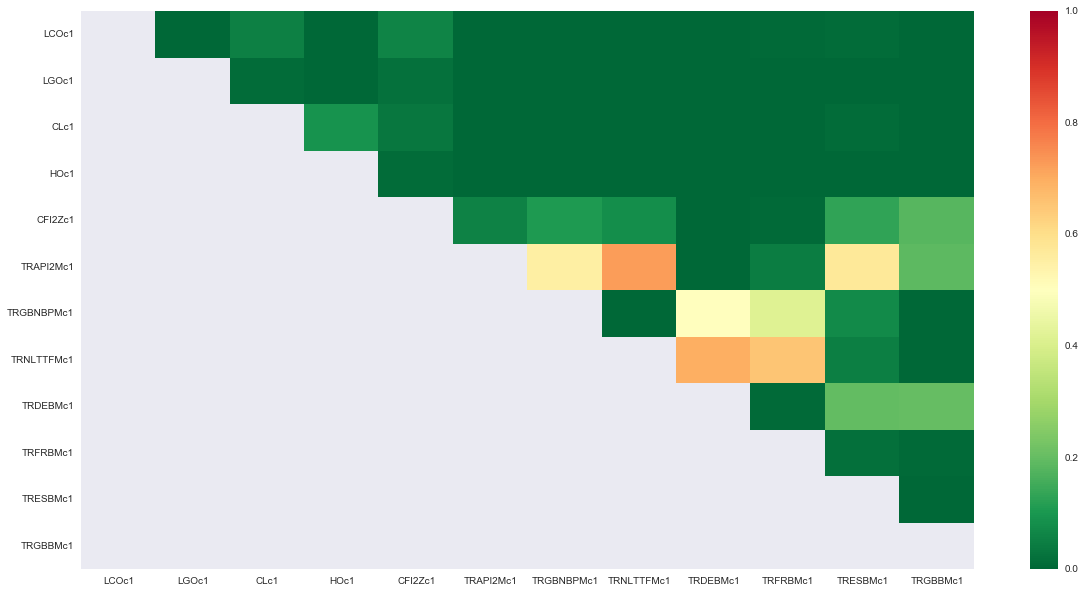

In [70]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

scores, pvalues, pairs = find_cointegrated_pairs(df)
_ = sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r', mask = (pvalues >= 0.95),
            #vmin=0.0, vmax=0.1
           )

### Brent crude vs Heating Oil

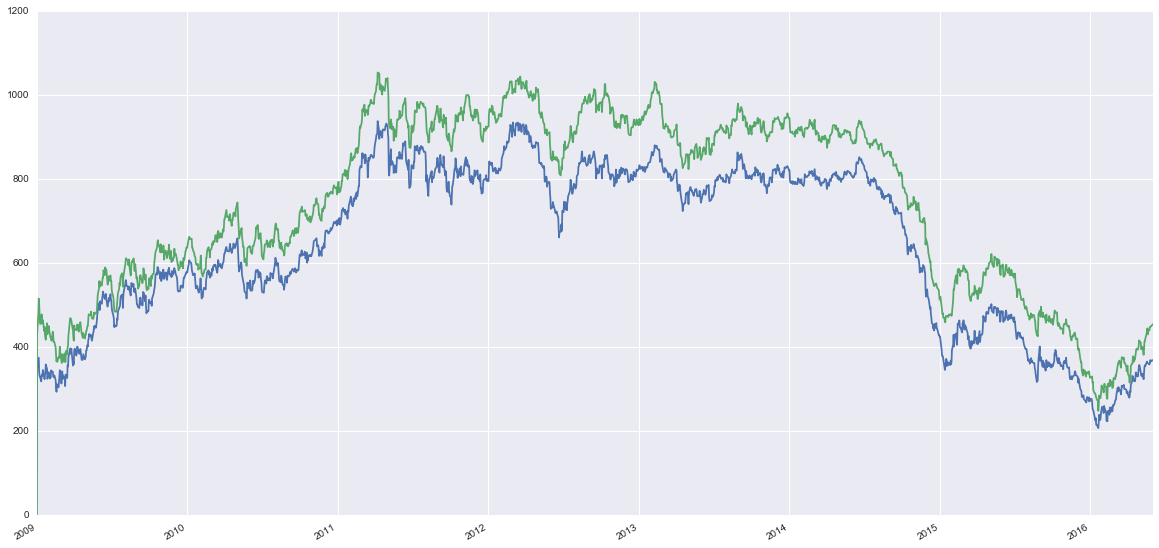

In [50]:
(df.LCOc1*7.4).plot()
df.LGOc1.plot()

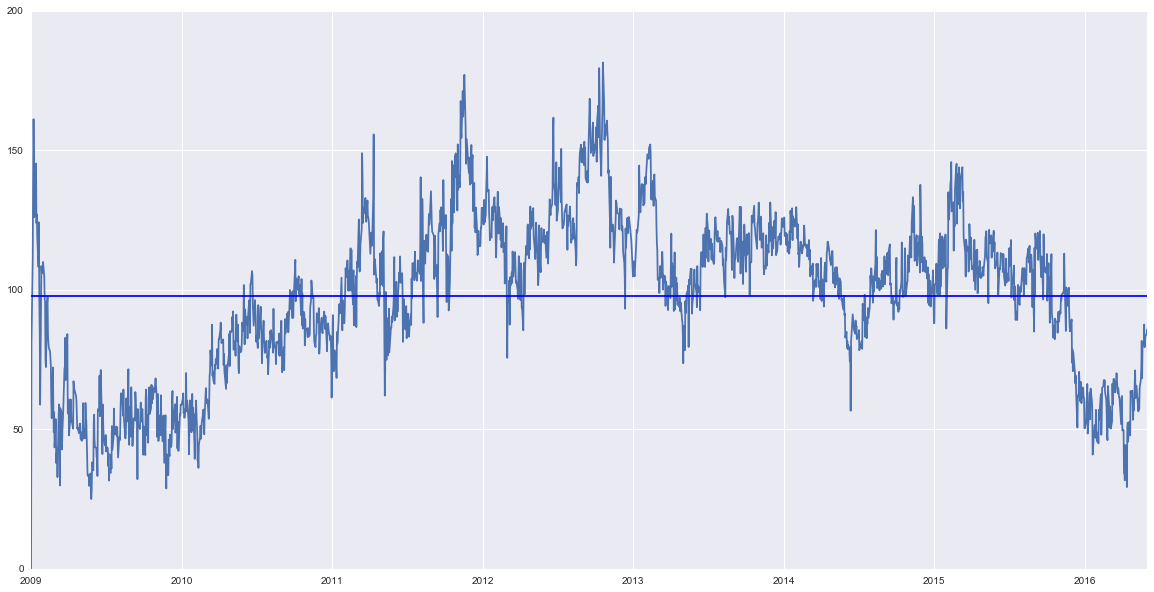

In [58]:
import matplotlib.pyplot as plt
r = df.LGOc1-7.4*df.LCOc1
plt.plot(r)
plt.axhline(r.mean())


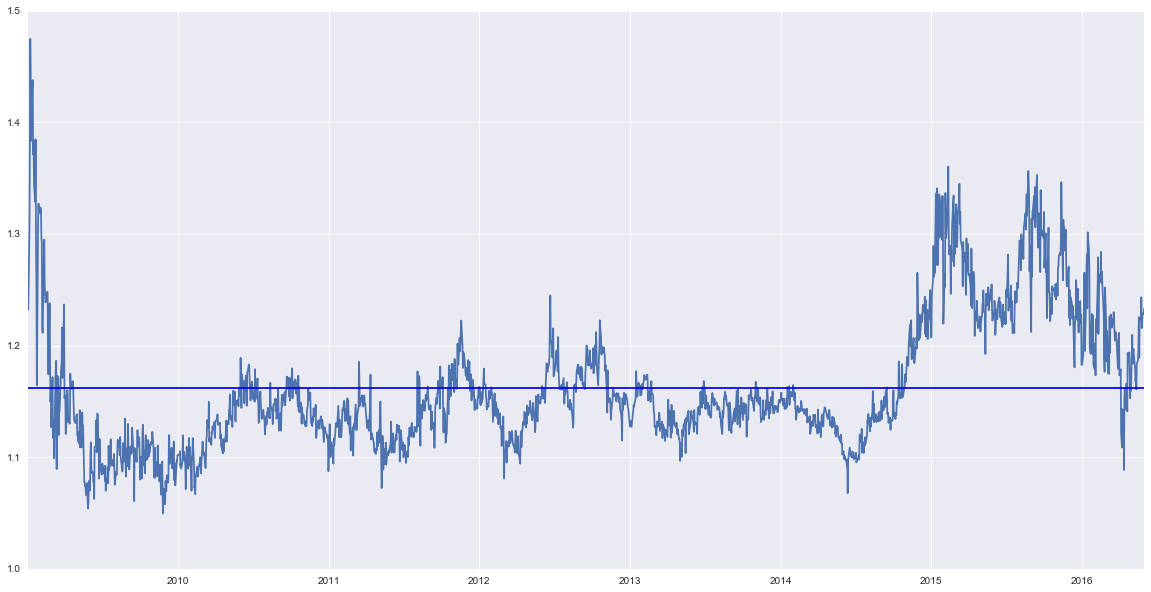

In [57]:
r2 = df.LGOc1/(7.4*df.LCOc1)
plt.plot(r2)
plt.axhline(r2.mean())

### Corn, Soya & Wheat Futures

In [76]:
import parse_data
reload(parse_data)

df2 = parse_data.parse_data(start_date, end_date, ["Cc1", "Sc1", "Wc1"])

ValueError: rics must be a string or a list of strings